In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler
import torch.nn as nn
import numpy as np
import pandas as pd
print(torch.__version__)

import matplotlib.pyplot as plt
import scipy.stats as sp

1.3.1


## Building some intuition First

Prior networks split the learning function into:
- Trainable part (Q)
- Scale (beta)
- Prior (P)

\begin{equation}
Q_{\theta}(x) = \underbrace{f_\theta(x)}_{\text{trainable}} + \overbrace{\beta}^{\text{scaling}} \underbrace{p(x)}_{\text{prior}}. \tag{1}
\end{equation}

In [2]:
np.random.seed(10)

In [3]:
# generating big and small datasets
X = np.random.uniform(0.0, 0.5, 100).reshape(-1,1)

# let us generate a grid to check how models fit the data
x_grid = np.linspace(-5, 5, 1000).reshape(-1,1)

# defining the function - noisy
noise = sp.norm(0.00, 0.02)
target_toy = lambda x: (x + 0.3*np.sin(2*np.pi*(x + noise.rvs(1)[0])) + 
                        0.3*np.sin(4*np.pi*(x + noise.rvs(1)[0])) + 
                        noise.rvs(1)[0] - 0.5)

# runnning the target
y = np.array([target_toy(e) for e in X])

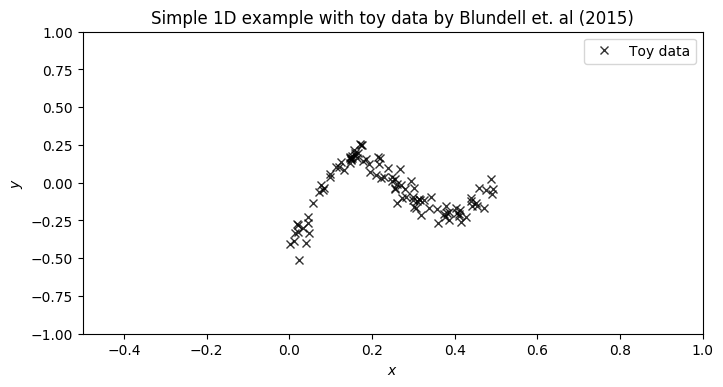

In [4]:
plt.figure(figsize=[8,4], dpi=100)

# first plot
plt.plot(X, y, 'kx', label='Toy data', alpha=0.8)
plt.title('Simple 1D example with toy data by Blundell et. al (2015)')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(-0.5,1.0); plt.ylim(-1.0,1.0)
plt.legend();
plt.show()

In [5]:
x_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32)
x_grid = torch.tensor(x_grid, dtype=torch.float32)
x_train.shape, y_train.shape, x_grid.shape, x_train.dtype, y_train.dtype, x_grid.dtype

(torch.Size([100, 1]),
 torch.Size([100, 1]),
 torch.Size([1000, 1]),
 torch.float32,
 torch.float32,
 torch.float32)

In [6]:
class ModelWithPrior(nn.Module):
    def __init__(self,
                 base_model : nn.Module,
                 prior_model : nn.Module,
                 prior_scale : float = 1.0):
        super().__init__()
        self.base_model = base_model
        self.prior_model = prior_model
        self.prior_scale = prior_scale

    def forward(self, inputs):
        with torch.no_grad():
            prior_out = self.prior_model(inputs)
            prior_out = prior_out.detach()
        model_out = self.base_model(inputs)
        return model_out + (self.prior_scale * prior_out)

In [7]:
class PriorNet(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(PriorNet, self).__init__()

        self.h1 = torch.nn.Linear(n_input,n_hidden)
        self.h2 = torch.nn.Linear(n_hidden, n_output)
        # nn.init.xavier_uniform_(self.h1.weight)
        # nn.init.xavier_uniform_(self.h2.weight)
        self.h1.requires_grad_=False
        self.h2.requires_grad_=False

    def forward(self,inputs):
        x = self.h1(inputs)
        x = self.h2(x)
        return x

In [8]:
class Regressor(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Regressor, self).__init__()

        self.h1 = torch.nn.Linear(n_input,n_hidden)
        self.h2 = torch.nn.Linear(n_hidden,n_hidden)
        self.h3 = torch.nn.Linear(n_hidden, n_output)
        nn.init.xavier_uniform_(self.h1.weight)
        nn.init.xavier_uniform_(self.h2.weight)
        nn.init.xavier_uniform_(self.h3.weight)

    def forward(self,inputs):
        x = self.h1(inputs)
        x = nn.functional.selu(x)
        x = self.h2(x)
        x = nn.functional.selu(x)
        x = self.h3(x)
        return x

In [10]:
def train_simple_model(x_train, y_train, n_epochs, n_hidden=16):
    print(x_train.shape)
    INPUT_SHAPE = x_train.shape[1]
    N_HIDDEN = n_hidden
    OUTPUT_SHAPE = y_train.shape[1]
    print(INPUT_SHAPE, OUTPUT_SHAPE )
    model = Regressor(INPUT_SHAPE, N_HIDDEN, OUTPUT_SHAPE)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    for epoch in range(n_epochs):
        model.train()
        preds = model(x_train)
        loss = loss_fn(preds, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch%(n_epochs/10) ==0:
            print("Epoch: {} - Loss: {:.4f}".format(epoch, loss.item()))
    return model

In [11]:
model_1 = train_simple_model(x_train, y_train, n_epochs = 600, n_hidden=32)

torch.Size([100, 1])
1 1
Epoch: 0 - Loss: 4.2352
Epoch: 60 - Loss: 0.0326
Epoch: 120 - Loss: 0.0277
Epoch: 180 - Loss: 0.0245
Epoch: 240 - Loss: 0.0201
Epoch: 300 - Loss: 0.0142
Epoch: 360 - Loss: 0.0076
Epoch: 420 - Loss: 0.0042
Epoch: 480 - Loss: 0.0033
Epoch: 540 - Loss: 0.0029


In [12]:
preds = model_1.forward(x_grid)
preds.squeeze().shape

torch.Size([1000])

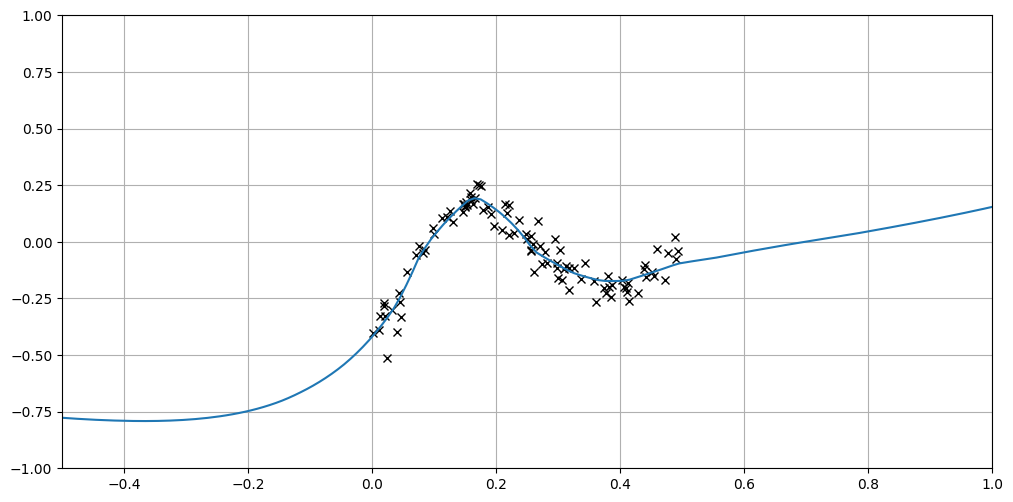

In [13]:
plt.figure(figsize=[12,6], dpi=100)
plt.plot(x_train,y_train, 'kx')
plt.plot(x_grid, preds.squeeze().detach().numpy())
plt.xlim(-0.5,1.0); plt.ylim(-1.0,1.0)
plt.grid()

In [15]:
def train_bootstrap_model(x_train, y_train, n_hidden, n_epochs, scale_value = 1.0 ):
    INPUT_SHAPE = x_train.shape[1]
    N_HIDDEN = n_hidden
    OUTPUT_SHAPE = y_train.shape[1]
    base_model = Regressor(INPUT_SHAPE, N_HIDDEN, OUTPUT_SHAPE)
    prior_model = PriorNet(INPUT_SHAPE, N_HIDDEN, OUTPUT_SHAPE)
    model = ModelWithPrior(base_model, prior_model, scale_value)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    print("TRAIN INIT -" + "-"*20)
    for epoch in range(n_epochs):
        model.train()
        preds = model(x_train)
        loss = loss_fn(preds, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch%(n_epochs/10) ==0:
            print("__Epoch: {} - Loss: {:.4f}".format(epoch, loss.item()))
    return model, prior_model

In [16]:
complete_model, prior_model = train_bootstrap_model(x_train, 
                                                    y_train, 
                                                    n_hidden = 32, 
                                                    n_epochs = 500, 
                                                    scale_value = 1.0
                                                    )

TRAIN INIT ---------------------
__Epoch: 0 - Loss: 0.1714
__Epoch: 50 - Loss: 0.0635
__Epoch: 100 - Loss: 0.0255
__Epoch: 150 - Loss: 0.0220
__Epoch: 200 - Loss: 0.0190
__Epoch: 250 - Loss: 0.0160
__Epoch: 300 - Loss: 0.0124
__Epoch: 350 - Loss: 0.0088
__Epoch: 400 - Loss: 0.0062
__Epoch: 450 - Loss: 0.0046


In [17]:
complete_preds = complete_model.forward(x_grid)
prior_preds = prior_model.forward(x_grid)
complete_preds.squeeze().shape, prior_preds.squeeze().shape

(torch.Size([1000]), torch.Size([1000]))

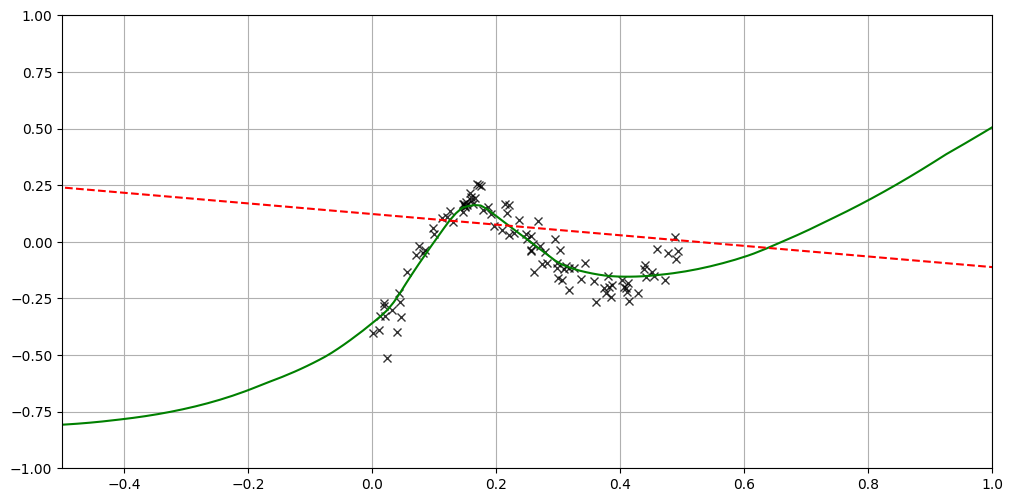

In [18]:
plt.figure(figsize=[12,6], dpi=100)
plt.plot(x_train, y_train, 'kx', alpha=0.8)
plt.plot(x_grid, complete_preds.squeeze().detach().numpy(),'g', label='resultant (q)')
plt.plot(x_grid, prior_preds.squeeze().detach().numpy(),'r--', label='prior net (p)')
plt.xlim(-0.5,1.0); plt.ylim(-1.0,1.0)
plt.grid()

## Ensemble Preds

In [19]:
k = 10
N_EPOCHS = 700
N_HIDDEN = 32
ensemble = [train_bootstrap_model(x_train, 
                                  y_train, 
                                  n_hidden = N_HIDDEN, 
                                  n_epochs = N_EPOCHS, 
                                  scale_value = 1.0) for i in range(k)]

TRAIN INIT ---------------------
__Epoch: 0 - Loss: 7.1546
__Epoch: 70 - Loss: 0.0297
__Epoch: 140 - Loss: 0.0235
__Epoch: 210 - Loss: 0.0196
__Epoch: 280 - Loss: 0.0130
__Epoch: 350 - Loss: 0.0074
__Epoch: 420 - Loss: 0.0043
__Epoch: 490 - Loss: 0.0034
__Epoch: 560 - Loss: 0.0030
__Epoch: 630 - Loss: 0.0028
TRAIN INIT ---------------------
__Epoch: 0 - Loss: 0.8720
__Epoch: 70 - Loss: 0.0276
__Epoch: 140 - Loss: 0.0181
__Epoch: 210 - Loss: 0.0142
__Epoch: 280 - Loss: 0.0099
__Epoch: 350 - Loss: 0.0067
__Epoch: 420 - Loss: 0.0048
__Epoch: 490 - Loss: 0.0041
__Epoch: 560 - Loss: 0.0036
__Epoch: 630 - Loss: 0.0033
TRAIN INIT ---------------------
__Epoch: 0 - Loss: 0.0342
__Epoch: 70 - Loss: 0.0325
__Epoch: 140 - Loss: 0.0273
__Epoch: 210 - Loss: 0.0263
__Epoch: 280 - Loss: 0.0249
__Epoch: 350 - Loss: 0.0223
__Epoch: 420 - Loss: 0.0183
__Epoch: 490 - Loss: 0.0124
__Epoch: 560 - Loss: 0.0080
__Epoch: 630 - Loss: 0.0054
TRAIN INIT ---------------------
__Epoch: 0 - Loss: 1.4303
__Epoch: 70

In [21]:
y_clip = np.hstack([ensemble[i][0].forward(x_grid).detach().numpy() for i in range(k)])
y_clip.shape

(1000, 10)

In [22]:
priors_clip = np.hstack([ensemble[i][1].forward(x_grid).detach().numpy() for i in range(k)])
priors_clip[:,1].shape

(1000,)

In [23]:
e_mean = y_clip.mean(axis=1)
e_std = y_clip.std(axis=1)

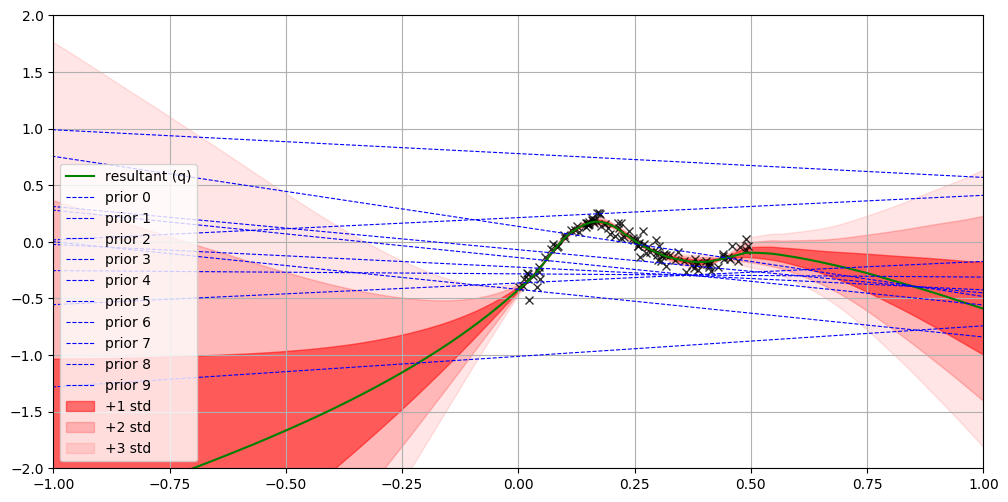

In [24]:
plt.figure(figsize=[12,6], dpi=100)
plt.plot(x_train, y_train, 'kx', alpha=0.8)
plt.plot(x_grid, e_mean,'g', label='resultant (q)')
for i in range(k):
    plt.plot(x_grid, priors_clip[:,i], 'b', label='prior {}'.format(i), linestyle='--', linewidth=0.8)
plt.fill_between(x_grid.squeeze(), e_mean - e_std, e_mean + e_std, alpha=0.5, label='+1 std', color='red')
plt.fill_between(x_grid.squeeze(), e_mean + 2*e_std, e_mean - 2*e_std, alpha=0.2, label='+2 std', color='red')
plt.fill_between(x_grid.squeeze(), e_mean + 3*e_std, e_mean - 3*e_std, alpha=0.1, label='+3 std', color='red')
plt.xlim(-1.0,1.0); plt.ylim(-2.0,2.0)
plt.legend()
plt.grid()